## Import library

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('IMDB Dataset.csv')

print("First 5 rows of the dataset:")
print(df.head())

print("\nDataset information:")
print(df.info())


First 5 rows of the dataset:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


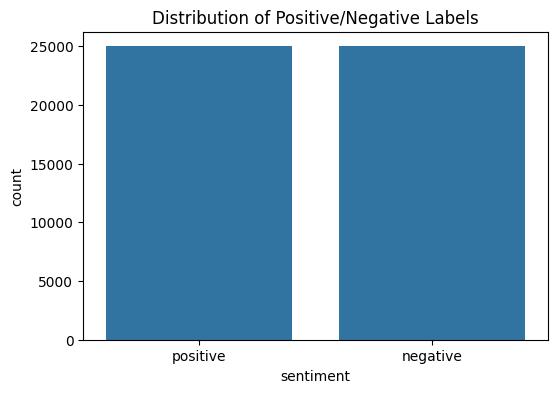

In [2]:
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Positive/Negative Labels')
plt.show()

## Cleaning Dataset

In [3]:

def clean_text(text):
    # Delete HTML tags
    text = re.sub(r'<br\s*/?>', ' ', text)
    # Remove special characters and numbers (optional, but with BERT it's good to keep punctuation as it understands context)
    # Here we only remove HTML and extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning
df['review'] = df['review'].apply(clean_text)

# Label Encoding
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

print("\nData after processing:")
print(df[['review', 'label']].head())


Data after processing:
                                              review  label
0  One of the other reviewers has mentioned that ...      1
1  A wonderful little production. The filming tec...      1
2  I thought this was a wonderful way to spend ti...      1
3  Basically there's a family where a little boy ...      0
4  Petter Mattei's "Love in the Time of Money" is...      1


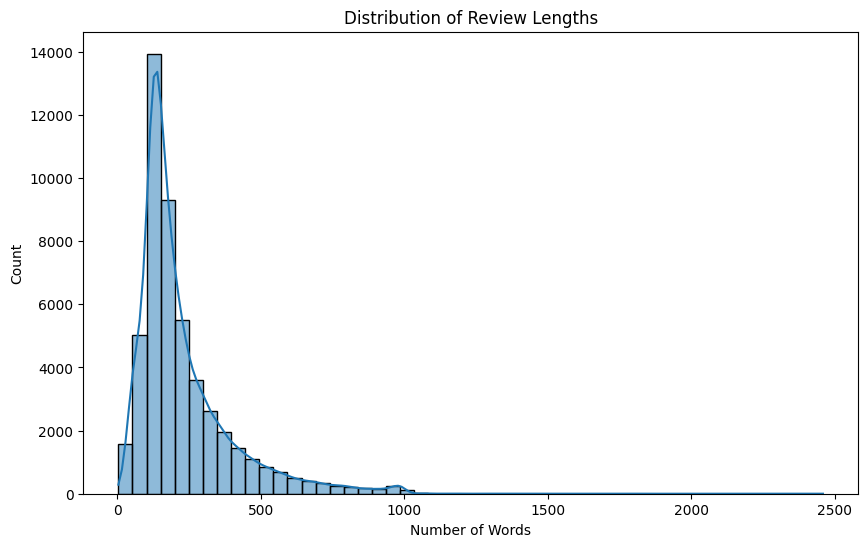

Average word count: 228.86876
Number of reviews longer than 512 words: 3598


In [4]:
# Word Count 
df['word_count'] = df['review'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Words')
plt.show()

print(f"Average word count: {df['word_count'].mean()}")
print(f"Number of reviews longer than 512 words: {sum(df['word_count'] > 512)}")

# Tokenize and normalize reviews

In [5]:
import torch
from transformers import DistilBertTokenizerFast
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Train/Validation Split

In [6]:
# For quick experiments, we sample a smaller subset of the data
data = df.sample(n=8000, random_state=42).copy() 

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    data['review'].values, 
    data['label'].values, 
    test_size=0.2, 
    random_state=42
)

print(f"Number of training samples: {len(X_train)}")
print(f"Number of validation samples: {len(X_val)}")

Number of training samples: 6400
Number of validation samples: 1600


## Initialize Tokenizer

In [14]:
# Download the tokenizer for DistilBERT
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

d:\HCMUT 2023\K251\DATH-TTNT\SimpleRNN\myvenv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Admin\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


## Create Custom Dataset Class

In [7]:
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        # Encode the text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,    # Add '[CLS]' and '[SEP]'
            max_length=self.max_len,    # Maximum length (truncate if longer)
            return_token_type_ids=False,
            padding='max_length',       # Pad with zeros to max length
            truncation=True,            # Truncate if too long
            return_attention_mask=True, # Create attention mask (to ignore padded zeros)
            return_tensors='pt',        # Return PyTorch Tensor
        )

        return {
            'review_text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

## Create DataLoader

In [13]:
# Initialize the tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Initialize Dataset
train_dataset = IMDBDataset(X_train, y_train, tokenizer)
val_dataset = IMDBDataset(X_val, y_val, tokenizer)

# Initialize DataLoader
BATCH_SIZE = 16 # Depending on GPU VRAM, 16 or 32 is common

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


In [11]:
# Get a sample batch from the training DataLoader
sample_batch = next(iter(train_loader))

print("Keys in the batch:", sample_batch.keys())
print("Shape of input_ids:", sample_batch['input_ids'].shape) 
# Expected: [16, 256] (16 sentences, each with 256 tokens)
print("Shape of labels:", sample_batch['labels'].shape)
# Expected: [16]

Keys in the batch: dict_keys(['review_text', 'input_ids', 'attention_mask', 'labels'])
Shape of input_ids: torch.Size([16, 256])
Shape of labels: torch.Size([16])


## Fine tuning

In [14]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast
from torch.optim import AdamW   # recommended

# Load pre-trained model
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2  # We have 2 labels: Positive (1) and Negative (0)
)


model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
# Initialize optimizer
optimizer = AdamW(model.parameters(), lr=5e-5) # Small learning rate (5e-5) is standard for BERT

# Number of epochs
# With Transformers, only 2-3 epochs are usually enough. Training longer can lead to overfitting.
EPOCHS = 2

In [ ]:
import time

# Accuracy calculation function
def calculate_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# --- START TRAINING ---
for epoch in range(EPOCHS):
    print(f'\n======== Epoch {epoch + 1} / {EPOCHS} ========')
    
    # Training
    model.train() # Switch to training mode (enable Dropout, etc.)
    total_train_loss = 0
    
    for batch in train_loader:
        # Move data to GPU/CPU
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Clear old gradients
        model.zero_grad()

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        
        # Accumulate loss
        total_train_loss += loss.item()

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Average Training Loss: {avg_train_loss:.4f}")

    # Validation 
    model.eval() # Turn on evaluation mode (disable Dropout)
    total_eval_accuracy = 0
    
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad(): # No gradient calculation during testing for efficiency
            outputs = model(input_ids, attention_mask=attention_mask)
        
        # Get predictions (logits) and move to CPU for calculation
        logits = outputs.logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()
        
        total_eval_accuracy += calculate_accuracy(logits, label_ids)

    print(f"Validation Accuracy: {total_eval_accuracy / len(val_loader):.4f}")



======== Epoch 1 / 2 ========
Average Training Loss: 0.3288
Validation Accuracy: 0.9000

======== Epoch 2 / 2 ========
Average Training Loss: 0.1675
Validation Accuracy: 0.8931


In [26]:
# Lưu mô hình và tokenizer
model.save_pretrained("imdb_sentiment_model")
tokenizer.save_pretrained("imdb_sentiment_model")

('imdb_sentiment_model\\tokenizer_config.json',
 'imdb_sentiment_model\\special_tokens_map.json',
 'imdb_sentiment_model\\vocab.txt',
 'imdb_sentiment_model\\added_tokens.json',
 'imdb_sentiment_model\\tokenizer.json')

In [28]:
import torch.nn.functional as F

def predict_sentiment(text):

    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=256,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    
    # Process the output
    logits = outputs.logits
    probs = F.softmax(logits, dim=1) # Convert to probabilities (0-1)
    
    # Get the label with the highest probability
    pred_label = torch.argmax(probs, dim=1).item()
    confidence = probs[0][pred_label].item()
    
    label_map = {1: 'POSITIVE', 0: 'NEGATIVE'}
    
    print(f"Review: {text}")
    print(f"Dự đoán: {label_map[pred_label]} ({confidence*100:.2f}%)")
    print("-" * 50)

# Testing the sentiment prediction
predict_sentiment("This movie is absolutely fantastic! The acting was superb.")
predict_sentiment("I wasted 2 hours of my life. Worst movie ever.")
predict_sentiment("The film had such a Grea moments, but overall it was quite boring.")
predict_sentiment("The best part of the movie was the ending credits.") 
predict_sentiment("Oscar-worthy acting in a script written by a 5-year-old.")
predict_sentiment("This movie is a perfect cure for insomnia.")

Review: This movie is absolutely fantastic! The acting was superb.
Dự đoán: POSITIVE (99.60%)
--------------------------------------------------
Review: I wasted 2 hours of my life. Worst movie ever.
Dự đoán: NEGATIVE (99.33%)
--------------------------------------------------
Review: The film had such a Grea moments, but overall it was quite boring.
Dự đoán: NEGATIVE (96.62%)
--------------------------------------------------
Review: The best part of the movie was the ending credits.
Dự đoán: POSITIVE (95.97%)
--------------------------------------------------
Review: Oscar-worthy acting in a script written by a 5-year-old.
Dự đoán: POSITIVE (91.07%)
--------------------------------------------------
Review: This movie is a perfect cure for insomnia.
Dự đoán: POSITIVE (94.26%)
--------------------------------------------------
